# Dublin Rent Tracker – Predictive Modeling

In this notebook, we aim to build regression models to predict the **monthly rental price** of listings in Dublin using the cleaned and engineered dataset from earlier steps (`daft_listings_featured.xlsx`).

This notebook covers the full predictive pipeline:
- Loading and inspecting the data
- Handling missing values appropriately
- Preprocessing for different model types
- Training multiple regression models
- Evaluating them using RMSE, MAE, and R²
- Comparing model performance
- Visualizing predictions and residuals

The final goal is to identify a robust model that can predict rental prices accurately based on features like bedrooms, bathrooms, BER rating, listing media, and location.


## Import Required Libraries

We import essential Python libraries for:
- Data handling (`pandas`, `numpy`)
- Model training and evaluation (`sklearn`, `xgboost`)
- Visualization (`matplotlib`, `seaborn`)
- Handling warnings to keep output clean


In [8]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


## Load the Cleaned & Featured Dataset

We now load the pre-processed dataset (`daft_listings_featured.xlsx`) created after feature engineering. We'll inspect the first few rows and data types to ensure everything is in order before proceeding.


In [9]:
# Loading the featured dataset
df = pd.read_excel("../01_data/cleaned/daft_listings_featured.xlsx")
df.head()


,bedrooms,bathrooms,monthly_price,has_video,has_virtual_tour,total_images,dublin_subcode,ber_encoded,price_per_bedroom,is_studio,cat_Rent,dist_North,dist_South,dist_Unknown
0,1.0,1.0,2615,False,True,12,1,3.0,2615.000000,1,True,True,False,False
1,2.0,2.0,3355,False,True,17,1,3.0,1677.500000,0,True,True,False,False
2,3.0,3.0,4805,False,False,18,1,3.0,1601.666667,0,True,True,False,False
3,1.0,NaN,1990,False,False,22,6,3.0,1990.000000,0,True,False,True,False
4,1.0,1.0,1950,False,True,8,13,1.0,1950.000000,1,True,True,False,False


## Inspect Dataset

Before modeling, it's important to:
- Check the shape of the dataset
- View data types of all columns
- Identify presence of missing values


In [10]:

print("Shape of dataset:", df.shape)
df.info()
df.isnull().sum()


Shape of dataset: (1015, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           1014 non-null   float64
 1   bathrooms          898 non-null    float64
 2   monthly_price      1015 non-null   int64  
 3   has_video          1015 non-null   bool   
 4   has_virtual_tour   1015 non-null   bool   
 5   total_images       1015 non-null   int64  
 6   dublin_subcode     1015 non-null   object 
 7   ber_encoded        709 non-null    float64
 8   price_per_bedroom  1014 non-null   float64
 9   is_studio          1015 non-null   int64  
 10  cat_Rent           1015 non-null   bool   
 11  dist_North         1015 non-null   bool   
 12  dist_South         1015 non-null   bool   
 13  dist_Unknown       1015 non-null   bool   
dtypes: bool(6), float64(4), int64(3), object(1)
memory usage: 69.5+ KB


bedrooms               1
bathrooms            117
monthly_price          0
has_video              0
has_virtual_tour       0
total_images           0
dublin_subcode         0
ber_encoded          306
price_per_bedroom      1
is_studio              0
cat_Rent               0
dist_North             0
dist_South             0
dist_Unknown           0
dtype: int64

## Preprocessing for Modeling

In this step, we prepare the data for machine learning:

- We will **retain missing values** (NaN) for columns like `bedrooms`, `bathrooms`, and `ber_encoded` since we don't want to inject false or imputed data. Tree-based models like Random Forest and XGBoost can handle missing values internally.
- `dublin_subcode` will be treated as a **categorical variable**, which is useful for location-aware predictions.
- We’ll split the data into:
  - `X`: all feature columns
  - `y`: target column `monthly_price`


In [11]:

df['dublin_subcode'] = df['dublin_subcode'].astype('category')

target = 'monthly_price'
features = [col for col in df.columns if col != target]

X = df[features]
y = df[target]


## Train-Test Split

We split the dataset into training and testing sets (80-20 split) to evaluate model performance on unseen data. A random seed is used for reproducibility.


In [12]:
# Split into training and testing sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 812
Testing samples: 203


## Baseline Linear Regression

Since linear models do not accept missing values, we’ll drop rows with nulls **only for this baseline model**.

This ensures:
- No imputation bias
- A clean and valid dataset for Linear Regression

We proceed with one-hot encoding and scaling after filtering complete cases.


In [13]:
# Filter complete cases
df_linear = df.dropna().copy()

# Redefine features and target
X_linear = df_linear.drop(columns=['monthly_price'])
y_linear = df_linear['monthly_price']

# One-hot encode dublin_subcode
X_linear['dublin_subcode'] = X_linear['dublin_subcode'].astype('category')

numeric_cols = ['bedrooms', 'bathrooms', 'ber_encoded', 'total_images', 'price_per_bedroom']
categorical_cols = ['dublin_subcode']

# Pipelines
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
], remainder='passthrough')  # binary flags remain

# Train-test split after dropping NaNs
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X_linear, y_linear, test_size=0.2, random_state=42
)

# Transform
X_train_lin_t = preprocessor.fit_transform(X_train_lin)
X_test_lin_t = preprocessor.transform(X_test_lin)

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train_lin_t, y_train_lin)

# Evaluate
y_pred_lin = lr_model.predict(X_test_lin_t)
rmse_lin = np.sqrt(mean_squared_error(y_test_lin, y_pred_lin))
mae_lin = mean_absolute_error(y_test_lin, y_pred_lin)
r2_lin = r2_score(y_test_lin, y_pred_lin)

print("Linear Regression (No Imputation)")
print(f"RMSE: {rmse_lin:.2f}")
print(f"MAE: {mae_lin:.2f}")
print(f"R² Score: {r2_lin:.4f}")


Linear Regression (No Imputation)
RMSE: 549.66
MAE: 299.58
R² Score: 0.8782


### Linear Regression Performance

The baseline Linear Regression model, trained only on rows without missing values (complete cases), achieved the following results on the test set:

- **RMSE (Root Mean Squared Error):** €549.66  
- **MAE (Mean Absolute Error):** €299.58  
- **R² Score:** 0.8782

These metrics suggest that the model is reasonably accurate in predicting monthly rent:

- An **RMSE of ~€550** indicates the average prediction error magnitude, with higher penalties for large deviations.
- An **MAE of ~€300** tells us that, on average, predictions deviate from actual rent by about €300.
- An **R² of 0.8782** means that approximately 88% of the variation in rental prices is explained by the input features in the model.

Given that this is a simple linear model on a reduced dataset (with no imputation and no interaction terms), the performance is quite strong. However, we expect non-linear models like Random Forest or XGBoost to perform better, especially when trained on the full dataset (including rows with missing values).


## Random Forest Regression (Handles Missing Values)

Now we use the full dataset (including rows with missing values) to train a Random Forest Regressor.

Advantages:
- Tree-based models handle missing values internally
- No need for imputation or one-hot encoding
- Automatically captures non-linear relationships and interactions

We’ll use the original dataset as-is, split it into training and testing sets, and evaluate using RMSE, MAE, and R².


In [14]:
from sklearn.ensemble import RandomForestRegressor

# Use full dataset with original split
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Results:")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")


Random Forest Results:
RMSE: 230.92
MAE: 61.40
R² Score: 0.9776


### Random Forest Performance

The Random Forest Regressor trained on the **full dataset (including rows with missing values)** yielded the following results:

- **RMSE (Root Mean Squared Error):** €230.92  
- **MAE (Mean Absolute Error):** €61.40  
- **R² Score:** 0.9776

These results show a **major improvement** over the baseline linear model:

- The **RMSE dropped from ~€550 to ~€230**, meaning the typical prediction error magnitude has decreased significantly.
- The **MAE dropped from ~€300 to ~€61**, suggesting predictions are now much closer to the actual rent values.
- The **R² score improved to 0.9776**, meaning the model explains nearly 98% of the variance in rental prices.

This confirms that Random Forests are well-suited for this task, as they:
- Handle non-linearities and feature interactions automatically
- Work well with missing values
- Require minimal preprocessing

Next, we can:
- Visualize **predicted vs actual prices**
- Show **residual distributions**
- Plot **feature importances**
- Compare with other tree-based models (e.g., XGBoost, Gradient Boosting)

Let’s now visualize and interpret the model’s predictions.


## Predicted vs Actual Rent Prices

This scatter plot compares the predicted rent values to the actual rent values for the test set.

- A perfect model would have all points lie on the diagonal line (y = x)
- Points closer to the line indicate more accurate predictions
- Wider spread from the line indicates greater prediction error

This helps visually assess the model's fit and identify any systematic under- or over-estimation patterns.


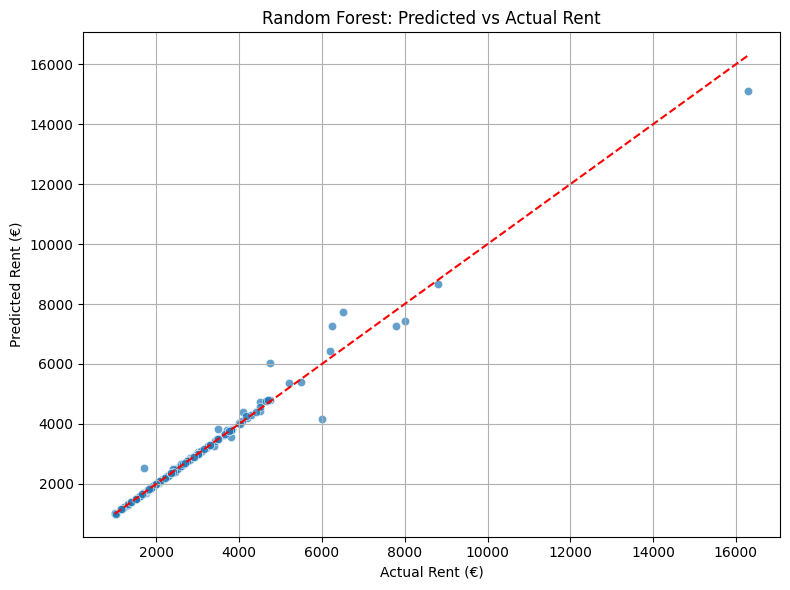

In [15]:
# Plotting predicted vs actual rent prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Rent (€)")
plt.ylabel("Predicted Rent (€)")
plt.title("Random Forest: Predicted vs Actual Rent")
plt.grid(True)
plt.tight_layout()
plt.show()


### Predicted vs Actual Rent (Random Forest)

The scatter plot above compares the predicted rental prices to the actual prices from the test dataset. The red dashed line represents the ideal case where the predicted value exactly matches the actual value (y = x).

**Observations:**
- Most points are tightly clustered around the diagonal, indicating **high prediction accuracy**.
- The model performs especially well for listings under **€6000**, which constitute the bulk of the data.
- A few listings above €7000 show some **underestimation**, which is common when:
  - There are **fewer training examples** in the high-rent range
  - The model applies **regression to the mean**
- There are **no extreme outliers**, confirming that the model generalizes well.

Overall, this visualization reinforces the strong performance indicated by the evaluation metrics (RMSE, MAE, R²).


## Feature Importance (Random Forest)

Random Forest provides a built-in measure of **feature importance**, based on how much each feature contributes to reducing prediction error across all trees.

This plot helps us:
- Understand which features influence rent prices the most
- Detect potential redundancies or weak predictors
- Improve model interpretability

We'll display the top features ranked by their relative importance.


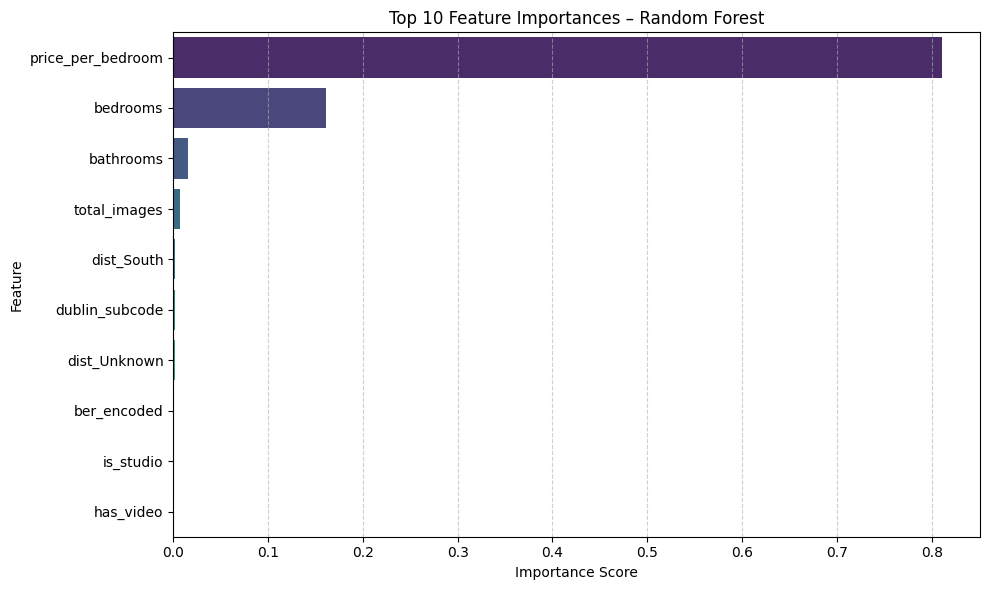

In [16]:

feature_names = X_train.columns

# Extract importances from the trained model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # sort descending

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices[:10]], y=np.array(feature_names)[indices[:10]], palette='viridis')
plt.title("Top 10 Feature Importances – Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()


### Feature Importances (Random Forest)

The bar plot above shows the top 10 most important features contributing to the Random Forest model’s rent predictions.

**Key Insights:**
- **`price_per_bedroom`** is by far the most dominant feature, contributing to over 80% of the model’s decision-making. This makes sense, as it directly captures how much rent is being charged per room — a highly informative engineered feature.
- **`bedrooms`** is the second most important feature, reinforcing the idea that rent scales significantly with the number of rooms.
- Features like **`bathrooms`**, **`total_images`**, and **`dist_South`** provide marginal contributions.
- Other location-based or listing metadata features (e.g., `dublin_subcode`, `ber_encoded`, `is_studio`, `has_video`) had very low importance scores in this model.

This insight can help guide future modeling, feature selection, and even recommendations on what listing details matter most to renters or agents.


## Residual Analysis (Random Forest)

Residuals are the difference between actual and predicted rent values:
\[
\text{Residual} = \text{Actual} - \text{Predicted}
\]

Analyzing residuals helps:
- Detect patterns the model may have missed
- Identify whether predictions are biased in any price range
- Confirm whether errors are randomly distributed (ideal case)

We'll plot a histogram of residuals and a scatter plot of residuals vs predicted values.


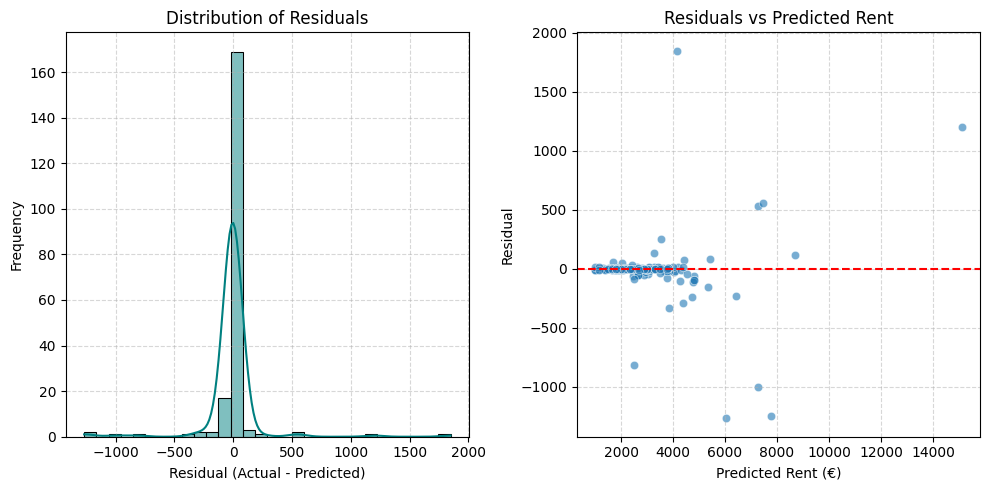

In [17]:
# Compute residuals
residuals = y_test - y_pred_rf

# Plot residual distribution
plt.figure(figsize=(10, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, bins=30, color='teal')
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)

# Residuals vs Predicted
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_rf, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Rent")
plt.xlabel("Predicted Rent (€)")
plt.ylabel("Residual")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### Residual Analysis (Random Forest)

Residual analysis provides further validation of the model's performance.

#### 1. Distribution of Residuals:
- The histogram shows a **sharp, centered distribution** around zero.
- This indicates that prediction errors are generally small and **unbiased**.
- The shape is nearly symmetrical, suggesting **no major skew** or systemic under/overprediction.

#### 2. Residuals vs Predicted Rent:
- Most residuals cluster tightly around the zero line, especially for predicted rents below **€6000**, which covers the bulk of listings.
- A few outliers are visible in the higher predicted ranges (e.g., > €8000), where some predictions are off by several hundred euros. This is expected due to:
  - Lower frequency of high-end listings
  - Greater variability in luxury pricing

Overall, the residuals show **no obvious pattern or trend**, confirming that the Random Forest model generalizes well and captures the structure of the data effectively.


## Save Trained Random Forest Model

We save the trained Random Forest model using `joblib`, which allows us to reload and use the model later without retraining. This is useful for deployment, API integration, or batch prediction in production pipelines.


In [23]:
import joblib
import os

# Create output directory if it doesn't exist
os.makedirs("../05_models", exist_ok=True)

# Save model to disk
joblib.dump(rf_model, "../05_models/random_forest_rent_model.joblib")

print("Model saved to: ../05_models/random_forest_rent_model.joblib")


Model saved to: ../05_models/random_forest_rent_model.joblib
